# Fine tune Mixtral-8x7B

This is a 7 billion parameter model, you can not compare with ChatGPT 4.5 or Sauna 4 because this model has way less parameters. The reason why we are going to fine tune this model is because it is a lot cheaper, we could also fine tune other open source model that have 100 of billions of parameters but it would cost thousands of dollars.

Our model is going to perform exceptionally well through the Fine tune. We are goin to make fine tune a lot cheaper and faster through the next methods:

1. Mix precision training
2. Quantization
3. LoRA

For the fine tune we are gonna be using databricks_dolly-15, which contains 15,000 samples manually generated by people at Databricks to train LLM.

The learning flow is going to be something like this

1. **Download:** the notebook is goign to download the dataset `databricks-dolly-15k` from Hugging Face
2. **Get the right format:** we are going to pass the data through format_dolly function, which is going to add some Headers.
3. **Upload:** We are goign to upload the data to S3
4. **Training:** the script `run_clm.py` is going to download the data from **S3** and give it to the Trainer

## The data from HuggingFace
The type of data we are going to be download from HuggingFace, `databricks-dolly-15k` it will look like:

```python

[
  {"instruction": "hola", "context" : "some context in here",  "response": "mundo"},      # dataset[0]
  {"instruction": "pregunta", "context": "some context here","response": "respuesta"} # dataset[1]
]
```

# Gathering, Chunking, Tokenizing and Uploading our Dataset

Sagemaker Sessions, Regions, and IAM Roles

In [ ]:
%pip install --quiet --upgrade transformers datasets sagemaker s3fs
# s3fs comunicate with S3 to save our traing data, the output model as well

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
   

In [ ]:
import sagemaker
import boto3 # python SDK for AWS

sagemaker.Session(): Es el "control remoto". Inicia la conexión entre tu código Python y la infraestructura de AWS. Gestiona las interacciones con S3 y los trabajos de entrenamiento.

In [ ]:
sess = sagemaker.Session() # your sagemaker session
# the output will be something like
# <sagemaker.session.Session as 0x7fe854f4af00>
sess

AttributeError: module 'sagemaker' has no attribute 'Session'

* get_execution_role(): Es el "pasaporte". Este notebook necesita permisos para leer datos de S3 y encender instancias GPU caras. Este rol de IAM (Identity and Access Management) le da permiso para hacerlo. Si este rol no tiene los permisos correctos, el código fallará más adelante al intentar subir datos.

* Región (boto_region_name): Es crítico que tu notebook y tu bucket de S3 (donde guardas los datos) estén en la misma zona geográfica (ej. us-east-1). Si no, AWS te cobrará extra por transferencia de datos y el entrenamiento podría fallar.

In [ ]:
# What permisions does our notebook has access to?
role = sagemaker.get_execution_role()
role # this is not your IAM role
# this is the rol of your sagemaker notebook
# this tells the notebook what it has access to

In [ ]:
# Where our notebook session is?
# the session must be the same with your s3 bucket
# Sometimes your training job dont even work if your training data
# is not in the same region as your notebook
sess.bot_region_name

Examining Our Dataset from HuggingFace

now we are going to load the dolly 15k which is a high quality set of prompt response pairs which has been generated by humans and it is perfect for instruccion fine tuning LLMs.

https://huggingface.co/datasets/databricks/databricks-dolly-15k

Let's load the data:

In [1]:
%cd /content/drive/MyDrive/Ideas/AI_Engineering_Customizing_LLMs_for_Business_(Fine-Tuning_LLMs_with_QLoRA_&_AWS)

/content/drive/MyDrive/Ideas/AI_Engineering_Customizing_LLMs_for_Business_(Fine-Tuning_LLMs_with_QLoRA_&_AWS)


In [2]:
from datasets import load_dataset
from random import randrange

dataset = load_dataset('databricks/databricks-dolly-15k', split='train') # we want to look at the train set

print(f'Dataset size; {len(dataset)}') # 15011
print(dataset[randrange(len(dataset))]) # select a random item from the entire length of the dataset

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Dataset size; 15011
{'instruction': 'What is a polygon?', 'context': '', 'response': 'A polygon is a form in Geometry.  It is a single dimensional plane made of connecting lines and any number of vertices.  It is a closed chain of connected line segments or edges.  The vertices of the polygon are formed where two edges meet.  Examples of polygons are hexagons, pentagons, and octagons.  Any plane that does not contain edges or vertices is not a polygon.  An example of a non-polygon is a circle.', 'category': 'open_qa'}


In [3]:
# this is an object from huggingface library
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
print(dataset.features)

{'instruction': Value('string'), 'context': Value('string'), 'response': Value('string'), 'category': Value('string')}


In [4]:
# Now let's use a function to convert our data into tasks prompts
def format_dolly(sample):
  instruction = f"### Instruction\n{sample['instruction']}"
  context = f"### Context\n{sample['context']}" if len(sample['context']) > 0 else None # when we dont have a context we want to provide None and later on we would filter out the Nones
  response = f"### Answer\n{sample['response']}"
  prompt = "\n\n".join([i for i in [instruction, context, response] if i is not None])# we only keep those values which are not None
  return prompt

In [ ]:
print(format_dolly(dataset[randrange(len(dataset))]))

### Instruction
How many awards did the film The Walrus and the Whistleblower win per this entry of information?

### Context
The Walrus and the Whistleblower is a 2020 Canadian documentary film directed by Nathalie Bibeau. The film profiles Phil Demers, a former employee of Marineland who attempted to blow the whistle on allegedly inhumane treatment of animals at the institution.

According to a film industry newsletter, the film was made "in association with the Documentary Channel, and CBC Docs". The Documentary Channel's announcement about the film stated that Demers had "appeared four times on the Joe Rogan show, has testified before the Canadian Senate, and is being sued for $1.5 million for plotting to steal Smooshi, the walrus".

The film premiered as part of the 2020 Hot Docs Canadian International Documentary Festival. Due to the COVID-19 pandemic in Canada it was not screened theatrically, but premiered as part of the festival's online streaming component and aired on CBC Te

HuggingFace Authentication with Sagemaker

In [5]:
import os

os.environ["HF_TOKEN"] = "hf_*************************************"

Tokenization and Word Embeddings

We have to tokenize the inputs then those tokenize inputs get a token ID, and then those token ID get look up on an embedding table.
Once we convert this words into words embedding then we can feed them into LLM that can uderstand it.

![](https://raw.githubusercontent.com/sebastianperezv/AI_Engineering_Customizing_LLMs_for_Buisness/refs/heads/main/Images/Tokenization.jpg)

## Padding

Con Padding (Usando EOS </s> que vale, digamos, 2):


[101, 204, 2, 2]    <-- "Hola mundo" + Relleno

[101, 204, 305, 400] <-- "Hola mundo cruel hoy"

In [6]:
from transformers import AutoTokenizer

model_id = "mistralai/Mixtral-8x7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Now we can tokenize the inputs
# After the tokenization it is going to give us a token ID
tokenizer.pad_token = tokenizer.eos_token # pad those sentences which are not long enough
# so it is going to be the same as the longer one
# It will ensure that each prompt has the same lenght that why we need the padding

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Applying the Templating Function to our Dataset

We are going to delete what we do not need adding to anew key called 'text'

In [7]:
from random import randint
from itertools import chain
from functools import partial

In [8]:
# we are going to create a text column
def template_dataset(sample):
  # Every sample is gonna have a text key
  # and the text key is what actually holds
  # all the information
  # we create a new key
  sample['text'] = f"{format_dolly(sample)}{tokenizer.eos_token}" # going to add <s> the model knows when the answer has finished
  return sample

In [9]:
template_dataset(dataset[randrange(len(dataset))])

{'instruction': 'road trip to Kerala from Bangalore.',
 'context': '',
 'response': "You can plan for a One Week Road trip from Bangalore to Entire Kerala.\n\nDay 1: Start early in the morning.First destination Munnar. You can reach Munnar in 10 hours. Stay in a nice hotel facing Tea estate. Relax for the day.\n\nDay 2 : Travel Munnar . You can change the hotel for Different view.\n\nDay 3 : Start after breakfast for Kochi, It's a port City. Reach Kochi near about 3 hours 30 minutes, visit kochi port beach walk . And stay at night near Marari beach , any sea facing resort(1 hr from Kochi) and \n\nDay 4 : Half an hour from Marari beach, go to Alyppe (Alappuzha) , Stay boat house. This is Beautiful!!  Enjoy the Alappuzha Lake ride in your boat.\n\nDay 5 : Go to Varkala. Stop for Jatayu earth center , this is outstanding. Varaka has very nice beach shopping and restaurant .\n\nDay 6 : Go to Poovar, there any many nice sea facing resort. And do not forget to go for Mangrove tour.\n\nDay 7 

In [10]:
dataset.features

{'instruction': Value('string'),
 'context': Value('string'),
 'response': Value('string'),
 'category': Value('string')}

how do we applied the template_dataset function to the entire dataset. We use map

In [11]:
# We just want the text column
# we are going to delete all the other features
dataset = dataset.map(template_dataset, remove_columns=list(dataset.features))

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [12]:
dataset.features

{'text': Value('string')}

In [13]:
dataset[1]

{'text': '### Instruction\nWhich is a species of fish? Tope or Rope\n\n### Answer\nTope</s>'}

In [14]:
# you will be able to see the special toke
# the llm now knows that over there we are ending the current sequence
print(dataset[randint(0, len(dataset))]['text'])

### Instruction
Why did Georges think that Helene redirected her affections towards Walter Rogers?

### Context
Papa Chibou (Paul Muni), the elderly caretaker of Musée Pratouchy, a Parisian wax museum, feels a strong kinship with the figures, particularly with that of Napoleon. He spots at the waxworks a romantic young couple, Georges (Russell Gleason), a lawyer, and Helene (Marguerite Churchill), the daughter of a stern judge (Lester Lonergan) who disapproves of his daughter's choice and forbids her to see Georges. Papa Chibou suggests to them that they can still stay in touch, without disobeying her father's directive not to speak with each other, by placing secret personal messages in the pockets of Napoleon's uniform. However, a missing letter and confusion in communication causes Georges to arrive at the mistaken conclusion that Helene has redirected her affections towards a foolish young man (Walter Rogers), who is unworthy of her and excessively preoccupied with his stylish pers

Attention Masks and Padding

# Reminder dictionary

A remainder dictionary is when you cut of the prompts

* **input_ids**: this are the token IDs for each word.

* **attention_mask**: remember that we want to make sure that each input is consitence, so it has the same lenght, well to do that we need to do padding. And when we pad we say, they must have a fix lenght, but some of them are shorter than the others so we pad them out, that's why there are zeros at the end. So, the attention mask, it tells the model the actual tokens by one, and uses zero for padding, so the modelwould only pay attention to the ones.

* **token_type_ids**: Mixtrat does not have token_type_id. But BERT does have it for sentences classification, encoder only model.
This tell a enconder only model, like the BERT model, which word belog to which sentence.
> Example: The dog ate the food. The other dog was sad. I ran away.
[0,0,0,0,0,1,1,1,1,1,2,2,2]

**chunk lenght** = max 2048 (more than that we need to cut it of)

90% of the prompts are gonna fit in 2048 token lenght.
The remining 10% might not fit, and might have to cut them off and put the reminders at reminder and it will be process with the next batch.

## Example

......Machine learning is amazing.


remainder = ('input_ids': [1222,3000,2,890],
'attention_mask': [1,1,1,1],
             'token_type_ids': [] )


## The Mistral model

We will never going to have an attention mask where we have zeros, because, we are maximizing the traing through flattening them, thats why we have a fix lenght of 2048.
inputs_ids = attention_mask

**El Ejemplo (Chunk de 10)**
**Frase Real:** "Yo salí a jugar" + `</s>` (EOS)

**1. Input IDs (Lo que entra a la GPU)**

Aquí ocurre algo curioso. Como configuramos `pad_token = eos_token`, los huecos vacíos se rellenan también con el ID 2.

`[101, 234, 33, 222, 2, 2, 2, 2, 2, 2]`

* Azul (Datos): `101, 234, 33, 222` (Texto)

* Verde (Stop): `2` (El `</s>` que se utilizó para indicar fin)

* Gris (Relleno): `2, 2, 2, 2, 2` (El `</s>` que el SISTEMA puso para llenar el hueco)

**2. Attention Mask (El Árbitro)**

Aquí es donde el modelo distingue cuál "2" es importante y cuál es basura.

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

Los primeros cinco `1`: Incluyen el texto Y el primer `</s>`. El modelo DEBE prestar atención a ese primer `2` para aprender cuándo callarse.

Los siguientes cinco `0`: Le dicen al modelo: "Aunque veas un número 2 aquí, ignóralo. No aprendas nada de esto. Es solo soporte estructural".

![](https://raw.githubusercontent.com/sebastianperezv/AI_Engineering_Customizing_LLMs_for_Buisness/refs/heads/main/Images/Attention_mask.jpg)

In [ ]:
remainder = {'input_ids': [],
             'attention_mask': [],
             'token_type_ids': [] } # Empty

# Confiusing code we are going to be encoutering

We do not need this on AWS SageMaker jupyterlab

## Star Unpacking with Python

Refresher some of the python sintax.

Star unpacking, unpacks the elements of an iterable into individual items.

In [ ]:
def introduce(name, age, city):
  print(f"Hello, my name is {name}. I am {age} years old and live in {city}")

In [ ]:
person_info = ['Alice', 30, "New York"]

In [ ]:
# Scenario A: The WRONG way (without the * operator
introduce(person_info)

TypeError: introduce() missing 2 required positional arguments: 'age' and 'city'

In [ ]:
# Scenario B: The RIGHT way (with the * Operator)
# the * is going to unpack the list
introduce(*person_info)

Hello, my name is Alice. I am 30 years old and live in New York


## itertools import chain

`chain()`: takes multiple list and link them together end to aend in to a single sequence. We need to use `list()` to read in and access the elements

**El Problema**: Los modelos como Mixtral tienen una "ventana de contexto" fija (en tu código definida como 2048 tokens).

* Si una frase tiene 100 tokens, tendrías que rellenar (padding) con 1948 ceros. Esto es un desperdicio enorme de cómputo y dinero.

* Si una frase tiene 3000 tokens, se cortaría y perderías información.

**La Solución (la función chunk)**: El código implementa una estrategia de flujo continuo:

1. Aplanar (Flatten): Toma todos los ejemplos del dataset y los concatena en una fila india interminable de tokens.

2. Trocear (Slice): Corta esa fila exactamente cada 2,048 tokens.

3. Gestión de Residuos: Si al final de un lote sobran tokens (el "remainder"), no los tira. Los guarda y los pone al principio del siguiente lote.

**Beneficio:** El modelo siempre recibe bloques llenos de información (2048 tokens reales) sin desperdiciar ni un solo ciclo de GPU en "padding".

In [15]:
from itertools import chain

This is an example sample where 1 batch has 3 chunks. When we do the map in forwards steps, we will be using 1 batch with 1000 samples. Here the data is already tonekized.

In [40]:
# sample represents a simple batch of data
sample = {
    # Token IDs
    'input_ids': [
        # I   Like  Food
        [101, 4983, 2], # dataset[0]['text']
        [101, 2023, 2003, 2], # dataset[1]['text']
        [101, 2759, 2007, 4937, 2] # dataset[2]['text']
    ],
    'attention_mask': [
        # On Mistral model we have fix size chunk lenght of
        # 2048
        # On each chunk we want 2048 token
        [1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ]
}

The goal is to take all the input_ids and flatt them out in to a single array because we want to chop it up into uniform chunck length each equal to 2048:
[101, 4983, 102, 101, 2023, 2003, 102, 101, 2759, 2007, 4937, 102]

Once we flatt them out we can cho it up into the chunck sizes that we desire. And when we go back to fine tunning tha chunck size is going to be 2048.
[101, 4983, 102, CHOP HERE 101, 2023, 2003, CHOP HERE 102, 101, 2759, CHOP HERE 2007, 4937, 102]

In [41]:
print(sample)

{'input_ids': [[101, 4983, 2], [101, 2023, 2003, 2], [101, 2759, 2007, 4937, 2]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [42]:
list(chain(*sample['input_ids']))

[101, 4983, 2, 101, 2023, 2003, 2, 101, 2759, 2007, 4937, 2]

In [43]:
# flatten the input array
# keys: input_ids, attention_mask

concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
# list(chain()) make the combination from [101, 4983, 2], [101, 2023, 2003, 2], [101, 2759, 2007, 4937, 2]
# to [101, 4983, 2, 101, 2023, 2003, 2, 101, 2759, 2007, 4937, 2]
concatenated_examples

{'input_ids': [101, 4983, 2, 101, 2023, 2003, 2, 101, 2759, 2007, 4937, 2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The concatenated_example is a dictionary hat has to keys: input_ids and attention_mask


## Understanding Batching

We are going to talk about the remainder and how we deal with it.

From the batches we are going to create chunks and each chunck soulg have a size of 2048. But this is not a eprfect owrld so we are gonna have remainders and we dont wanna throw out usefull training data so we just wanna put the remainder in the next batch,

In [59]:
from itertools import chain

remainder = {'input_ids': [], 'attention_mask': []}
print("----Initial State----")
print(f'Initial Remainder: {remainder}\n')

----Initial State----
Initial Remainder: {'input_ids': [], 'attention_mask': []}



### Round 1

In [44]:
batch_1 = {
    'input_ids': [
        [101, 4983, 2],
        [101, 2023, 2003, 2],
        [101, 2759, 2007, 4937, 2]
    ],
    'attention_mask': [
        [1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ]
}

In [45]:
print('1. Input for Round 1:', batch_1)

1. Input for Round 1: {'input_ids': [[101, 4983, 2], [101, 2023, 2003, 2], [101, 2759, 2007, 4937, 2]], 'attention_mask': [[1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1, 1]]}


In [58]:
concatenated_examples = {k: list(chain(*batch_1[k])) for k in batch_1.keys()}
print("\n2. After flattening Batch 1:", concatenated_examples)


2. After flattening Batch 1: {'input_ids': [101, 4983, 2, 101, 2023, 2003, 2, 101, 2759, 2007, 4937, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [60]:
# This is the second line: prepending the (currently empty) remainder
# we are adding the remainders to the current chunck
final_stream = {
    k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()
}

In [61]:
print("\n3. Final stream after adding remainder:", final_stream)


3. Final stream after adding remainder: {'input_ids': [101, 4983, 2, 101, 2023, 2003, 2, 101, 2759, 2007, 4937, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


For demostration let's calculate what the reminder Would be

In [62]:
# For demostration let's calculate what the reminder Would be
# we will use a chunk leght of 10. The stream has 12 tokens
# So, the remainder will be at last 2 tokens
# items() we access the keys and the values
remainder = {k: v[10:] for k, v in final_stream.items()}

In [63]:
print("\n4. New remainder calculated for next round:", remainder)


4. New remainder calculated for next round: {'input_ids': [4937, 2], 'attention_mask': [1, 1]}


### Round 2

In [64]:
batch_2 = {
    "input_ids": [
        [21, 22, 23, 24, 2],
        [26, 27, 28, 29, 2]
    ],
    "attention_mask": [
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ]
}

print("1. Input for Round 2:", batch_2)
print(f"(Note: the current remainder from round 1 is: {remainder})")

1. Input for Round 2: {'input_ids': [[21, 22, 23, 24, 2], [26, 27, 28, 29, 2]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}
(Note: the current remainder from round 1 is: {'input_ids': [4937, 2], 'attention_mask': [1, 1]})


In [65]:
# First line again: flattening Batch 2
concatenated_examples = {k: list(chain(*batch_2[k])) for k in batch_2.keys()}
print("\n2. After flattening Batch 2:", concatenated_examples)


2. After flattening Batch 2: {'input_ids': [21, 22, 23, 24, 2, 26, 27, 28, 29, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [66]:
# Second line again: prepending the remainder FROM ROUND 1
final_stream = {
    k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()
}

In [67]:
print("\n3. Final Stream after adding remainder:", final_stream)


3. Final Stream after adding remainder: {'input_ids': [4937, 2, 21, 22, 23, 24, 2, 26, 27, 28, 29, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


## Slicing and Chunking our Dataset

In [32]:
# SETUP
# we are going to use chunk of 5 tokens
# but for the fine tune project we will be using 2048
chunk_length = 5 # 2048

In [33]:
# This is our "Before" state. A dictioary where each key holds one long,
# continuous list of tokens
concatenated_examples = {
    'input_ids': [10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34],
    'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
}

In [34]:
# This is the total number of tokens we will slice up #1 5
batch_chunk_length = len(concatenated_examples['input_ids'])
print(batch_chunk_length)

15


In [35]:
# Before silicng
print("This is our long, continuous stream of tokens:")
print(concatenated_examples)

This is our long, continuous stream of tokens:
{'input_ids': [10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


### Silicing

In [36]:
# The operation
# this is the line of code that performs the slicing
# range(start, stop, step) -> (0, 15, 5)
result = {
    k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)] for k, t in concatenated_examples.items()
}

In [37]:
result

{'input_ids': [[10, 11, 12, 13, 14],
  [20, 21, 22, 23, 24],
  [30, 31, 32, 33, 34]],
 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}

In [38]:
# The result
print("----After Slicing----")
print("The stream has been chopped into a list of smaller lists (chunks):")
print(result)

----After Slicing----
The stream has been chopped into a list of smaller lists (chunks):
{'input_ids': [[10, 11, 12, 13, 14], [20, 21, 22, 23, 24], [30, 31, 32, 33, 34]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}


# Creating our Custom Chunking Function

We are going to define a function that will do everything for us. It will chunck up all the samples into length of 2048 tokens.

In [ ]:
def chunk(sample, chunk_length = 2048):

  global remainder # we want to be able to access the remainder dictionary to put the remainders in
  #print(len(sample['inputs_ids']), 'first') # we have a thousand samples
  #print(len(sample['inputs_ids'][999]), 'second') # the 1 thousand sample has this result of tokens

  concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}

  concatenated_examples = {
      k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()
  }

  batch_total_length = len(concatenated_examples[list(sample.keys())[0]]) # how long is 'input_ids'
  # print(batch_total_length, 'third') # total number of tokens in this batch
  aux = batch_total_length

  if batch_total_length > chunk_length: # 2048
    # How many chunks can we fit that perfectly set in 2048?
    batch_total_length = (batch_total_length // chunk_length) * chunk_length

  #print(batch_total_length,'fourth')
  # do the chunking
  result = {
      k: [t[i : i + chunk_length] for i in range(0, batch_total_length, chunk_length)] for k, t in concatenated_examples.items()
  }

  # the remainders are goin to be added to the remainder dictionary
  remainder = { # what is left
      k: concatenated_examples[k][batch_total_length:] for k in concatenated_examples.keys()
  }

  #print(batch_total_length,'fifth') # Number of chunks with 2048 tokens from the first batch
  #print(f'There will be {aux-batch_total_length} tokens from the first batch that will be put into the remainder dictionary, and that will be processed withth next batch')
  result['labels'] = result['input_ids'].copy()
  return result

# Tokenizing our Dataset

we just have finished the `chunk()` function which expects a sample.

Example of a sample:

```python
# this batch has 3 sample with their corresponding attention mask
sample = {
    # Token IDs
    'input_ids': [
        # I   Like  Food
        # Here they are tokenized
        [101, 4983, 102], # think like this is the prompt
        [101, 2023, 2003, 102],
        [101, 2759, 2007, 4937, 102]
    ],
    'attention_mask': [
        # On Mistral model we have fix size chunk lenght of
        # 2048
        # On each chunk we want 2048 token
        [1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1, 1]
    ]
}
```

Right now our code is not tokenized thats why we are gonna have to tokenized the whole dataset before we run the `chunk()` function.

`batched = True`
> by default the value for the batches size is a 1000. That means, when we call the chunk function we are gonna call it with a 1000 samples.
chunk() function will reciebe a 1000 tokenized samples and then it creates anew set of samples where eachs sample has a length 2048.

`remove_columns = list(dataset.features)`
> why are we doing this again?
We already have removed instruccion, context, response and category.
However, once we tokenize the entire input and we have the `result['labels']` we actually no longer need the `sample['text']` because we already have the input **tokenized**.

Explaining the next code:
```python
.map(
    partial(chunk, chunk_length),
    batched = True
)
```
What the partial does:
```python
def new_function(sample):
  # The chunk_length is already "frozen" to 2048
  return chunk(sample, chunk_length=2048)
```

In [ ]:
# Example
sample = tokenizer(dataset[:5]['text'])
sample

{'input_ids': [[1, 774, 3133, 3112, 13, 7477, 863, 8471, 6664, 1149, 10513, 28804, 13, 13, 27332, 14268, 13, 28790, 361, 6207, 6664, 28725, 272, 11674, 1141, 302, 8471, 6664, 28415, 367, 884, 14374, 28725, 349, 396, 9972, 28733, 5527, 2423, 1081, 28723, 661, 349, 272, 7639, 2423, 1081, 486, 17675, 1669, 298, 938, 272, 8471, 5804, 28723, 661, 901, 4697, 3345, 356, 28705, 28770, 28740, 3628, 28705, 28750, 28734, 28734, 28734, 390, 8471, 8836, 28725, 395, 989, 11475, 356, 264, 2692, 7103, 28723, 661, 6914, 1419, 3837, 390, 264, 3014, 2423, 1081, 297, 6664, 28742, 28713, 12866, 2668, 1024, 272, 17347, 302, 1094, 673, 28707, 6664, 297, 4074, 28705, 28750, 28734, 28734, 28740, 28723, 415, 2423, 1081, 659, 1854, 10039, 298, 5090, 7031, 28705, 28770, 28750, 9245, 297, 6664, 28725, 477, 14546, 28713, 297, 1896, 278, 28726, 1564, 28725, 19611, 304, 14469, 28723, 13, 13, 27332, 26307, 13, 28790, 361, 6207, 6664, 901, 4697, 3345, 356, 28705, 28770, 28740, 3628, 28705, 28750, 28734, 28734, 28734, 3

In [ ]:
result = chunk(sample=sample, chunk_length=5)

In [ ]:
result

{'input_ids': [[11, 12, 1, 774, 3133],
  [3112, 13, 7477, 863, 8471],
  [6664, 1149, 10513, 28804, 13],
  [13, 27332, 14268, 13, 28790],
  [361, 6207, 6664, 28725, 272],
  [11674, 1141, 302, 8471, 6664],
  [28415, 367, 884, 14374, 28725],
  [349, 396, 9972, 28733, 5527],
  [2423, 1081, 28723, 661, 349],
  [272, 7639, 2423, 1081, 486],
  [17675, 1669, 298, 938, 272],
  [8471, 5804, 28723, 661, 901],
  [4697, 3345, 356, 28705, 28770],
  [28740, 3628, 28705, 28750, 28734],
  [28734, 28734, 390, 8471, 8836],
  [28725, 395, 989, 11475, 356],
  [264, 2692, 7103, 28723, 661],
  [6914, 1419, 3837, 390, 264],
  [3014, 2423, 1081, 297, 6664],
  [28742, 28713, 12866, 2668, 1024],
  [272, 17347, 302, 1094, 673],
  [28707, 6664, 297, 4074, 28705],
  [28750, 28734, 28734, 28740, 28723],
  [415, 2423, 1081, 659, 1854],
  [10039, 298, 5090, 7031, 28705],
  [28770, 28750, 9245, 297, 6664],
  [28725, 477, 14546, 28713, 297],
  [1896, 278, 28726, 1564, 28725],
  [19611, 304, 14469, 28723, 13],
  [13, 273

In [ ]:
len(result)

3

Con `batched=True` (código actual): `sample['text']` se convierte en una Lista de Strings (de tamaño 1000). `["Hola mundo", "Instrucción 2", "Instrucción 3", ... hasta 1000]` (La función se ejecuta solo 15 veces para un dataset de 15k)

In [ ]:
lm_dataset = dataset.map(
    lambda sample: tokenizer(sample['text']), # your input is sample -> do tokenizer(sample['text'])
    batched = True, # sends 1000 of samples to the batch
    remove_columns = list(dataset.features) # why are we doing this again?
).map(
    partial(chunk, chunk_length=2048),
    batched = True
)

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [ ]:
print(f"Total number of samples: {len(lm_dataset)}") # you have this many chunks, and each is 2048 tokens long
# the number means you have for example 1528 chunks and each chunk has 2048 tokens long

Total number of samples: 1528


In [ ]:
# Guardar en formato binario
lm_dataset.save_to_disk("data/dataset_procesado")

Saving the dataset (0/1 shards):   0%|          | 0/1528 [00:00<?, ? examples/s]

In [ ]:
len(lm_dataset[0]['input_ids']),
len(lm_dataset[0]['attention_mask'])

2048

# Uploading the Training Data to AWS S3

Now we are going to upload our data and the tokenized data, our LLM dataset into S3. When we do the training process we are gonna be loading in the traning data from `S3`

`ideas-llm-dataset-2025`


In [ ]:
import s3fs

training_input_path = f's3://ideas-llm-dataset-2025/processed/mixtral/dolly/train'

lm_dataset.save_to_disk(training_input_path)
print("Uploading the data set to s3")

# Understanding LoRA and Setting up HuggingFace Estimator

Setting Up Hyperparameters for the Training Job

We just have finished uploading our dataset to S3. Now we are gonna start setting up the boilerplate code that we need in order to start off a SageMaker training job which in this case is going to be a fine-tuning job.

* merge_weights: True:
Este es un parámetro personalizado que lee el script run_clm.py. Le dice: "Al terminar, no me des solo los adaptadores sueltos. Fusiona $W + (B \times A)$ y guárdame un modelo final listo para usar".

In [ ]:
import time
from sagemaker.huggingface import HuggingFace

job_name = f"mixtral-8x7b-qlora-{time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())}"

hyperparameters = {
    'model_id': model_id,
    'dataset_path': '/opt/ml/input/data/training', # this is a specific path
    'epochs': 2, # At least 5 if the company is providing enough money
    'per_device_train_batch_size': 2, # this is the batch size for training. In every single step our system will process 8 exmples in paralel. (2 per device, 4 gpu)
    'lr': 2e-4,
    'merge_weights': True, # Indica que al finalizar, queremos fusionar los adaptadores LoRA con el modelo base para tener un solo modelo listo para usar, o mantenerlos separados.
}

Creating our HuggingFace Estimator in Sagemaker

This is an object that we can then call the dot fit method on it, wich starts the training, or in our case, the fine-tuning.

In [ ]:
huggingface_estimator = HuggingFace(
    entry_point = 'run_clm.py', # havent create this py file yet
    source_dir = 'scripts', # this is the directory which includes the entry point scripts and the requierements txt for pur training enviroment
    instance_type = 'ml.g5.24xlarge', # the instance that we are going to use to train our model. It has 4 GPUs.
    instance_count = 1, # Number of instances user for training
    base_job_name = job_name,
    role = role, # IAM role used in training to access AWS resources
    volume_size = 300, # size EBS volume in gigabytes
    transformers_version = '4.28', # Software versions
    pytorch_version = '2.0',
    py_version = 'py310',
    hyperparameters = hyperparameters,
    enviroment = {
        'HUGGINGFACE_HUB_CACHE': '/tmp/.cache'
    }
)

* data: Le dices dónde en S3 dejaste los datos procesados.

* .fit(): Aquí AWS hace lo siguiente:

1. Provisiona la instancia ml.g5.24xlarge (tarda unos 5 min).

2. Descarga la imagen de Docker de Hugging Face.

3. Descarga el código (run_clm.py) y tus datos desde S3.

4. Ejecuta python run_clm.py --epochs 2 ....

5. Cuando termina, guarda el modelo en S3 y apaga la máquina para que no sigas pagando.

In [ ]:
# last setup
data = {'training': training_input_path}
huggingface_estimator.fit(data, wait = True)

# What is LoRA?

When training LLM in each layer they have billions of weights, and updating all of them with backpropagation is very time consuming because that means we have to calculate all the gradients for those billions of parameters. Thats where LoRA comes in, and instead of calculating the gradients for all of the values in the weight matrix, we instead we break up W into to smaller matrices BA.

Weight matrix (*W* is a matrix in a space of real values with `k:rows` and `d:columns`):

$W \in \mathbb{R}^{k \times d}$

Break up *W*:

$\Delta W = BA$

So whenever there is gradients that we need to calculate we only calculate the Weight update for B and A, which are small matrices. That way we can essentially update the entire frozen W, which is a massive matrix with million of weights, we can updated but we dont updated by calculating the gradients for all the values inside of it, we just simple add or substract to it the chain in W which is the product of two smaller matrices B times A.

What we need to understand is that we are not calculating gradients for a large weight matrix, we are calculating gradients for smaller weight matrix BA, and then, once we multiply BA together, they are much smaller so they are more efficient, we add or substract the values to the original big *W* which was frozen.

The *r* or *rank* parameter is the most important hyperparameters that controlls the size and expressive power of the fine tunning update.

So instead re-training all the billion parameters in a LLM, `LoRA` freezes the original weights and inject a pair of samll trainable matrices B and A into that specific traget layer and r defines the inner dimensions of that matrices, meaning, if the original weights are a 1000 by 1000 matrix, the new matrices will be 1000 by r and r times 1000.

where:

* $A \in \mathbb{R}^{r \times d}$ is a small trainable matrix
* $B \in \mathbb{R}^{k \times r}$ is a small trainable matrix
* $r << \min(k, d)$ *r* is much smaller than *k* or *d*, where *k* is the input dimension of the layer and *d* is the output dimension

The effective weight becomes:

$W_{\text{eff}} = W + \Delta W = W + BA$

So only A and B receive gradient updates.

## Why use LoRA

* Full fine-tuning updates every weight tensor - expensive in memory and compute.
* LoRA reduces the number of trainable parameters by two or more orders of magnitude.
* In practice it achieves competitive downstream accuracy at a fraction of the cost.

When we fine tune a model, *W* is gonna have all the learn weights, so the mistral model that we are gonna fine tune has so much information and knows about the world war, mathematics, religion, etc. But does not know about our specific stuff that we want to fine tune on. That why we need to fit to our fit, we are not going to modify its weight, intead we add to it some of the weight training to *W*.

## LoRA Numerical Example

Keep in mind that $A$ and $B$ are smaller, they have far fewer total parameters to train. When youu multiply $B$ times $A$, the resulting matrix will have the same dimensions as the original matrix $W$ which is why the addition is mathematicaly valid.

Let

* input dim $d = 4$, output dim $k = 4$, rank $r = 2$

The initial matrices are:
$W = \begin{bmatrix}
1 & 0 & -1 & 2 \\
0 & 1 & 1 & -1 \\
2 & -2 & 0 & 0 \\
1 & 1 & 1 & 1
\end{bmatrix}$,
$A =
\begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
-0.1 & -0.2 & 0.0 & 0.1
\end{bmatrix}$,
$B\begin{bmatrix}
1 & 0 \\
0 & 1 \\
0.5 & -0.5 \\
-1 & 1
\end{bmatrix}$

The initial *$\Delta W$* and the efective weight matrix *$W_{\text{eff}}$* are caluclated as:

$\Delta W = BA = \Delta W = \begin{bmatrix}
0.1 & 0.2 & 0.3 & 0.4 \\
-0.1 & -0.2 & 0.0 & 0.1 \\
0.1 & 0.2 & 0.15 & 0.15 \\
-0.2 & -0.4 & -0.3 & -0.3
\end{bmatrix}$,
$
W_{\text{eff}} = W + \Delta W
\begin{bmatrix}
1.1 & 0.2 & -0.7 & 2.4 \\
-0.1 & 0.8 & 1.0 & -0.9 \\
2.1 & -1.8 & 0.15 & 0.15 \\
0.8 & 0.6 & 0.7 & 0.7
\end{bmatrix}$

## A single Gradient Update Step

Now, let's simulate one step pf training. We need an input vector $x$, a target output $y_{\text{true}}$, a $loss$ function *L*, and a learning rate $alpha$
* input: $x = [1,0,0,0$
* Target: $y_{\text{true}} = [1,1,1,1$
* Loss Function: L (Sum of Squared errors)
* Learning rate: $alpha = 0.1$

1. Forward pass: First, we compute the predicted output y = xWeff. With x = [1,0,0,0, this simply selects the first row of Weff cause the pther columns from x are zeros

$y = [1.1, 0.2, -0.7, 2.4 $

2. Compute Loss and Gradientes: We calculate the loss and then backpropagate to find the gradients of loss with respect $A$ and $B$:

$Loss = 2.75$

Crucially, since $W$ is **frozen** we do not compute its gradient. The gradients are computed only for the trainable parameters:
$\begin{aligned}
\nabla_W \mathcal{L} &= 0 \\
\nabla_A \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial A} \\
\nabla_B \mathcal{L} &= \frac{\partial \mathcal{L}}{\partial B}
\end{aligned}$

Via backpropagation, we find the numerical gradientes (values are approximate):

$\nabla_A \mathcal{L} = \begin{bmatrix}
0.1 & 0.2 & -1.7 & 1.4 \\
0 & 0 & 0 & 0
\end{bmatrix}$, $\nabla_B \mathcal{L} = \begin{bmatrix}
0.01 & -0.01 \\
0.02 & -0.02 \\
-0.17 & 0.17 \\
0.14 & -0.14
\end{bmatrix}$

3. Update Parameters: We update $A$ and $B$ using gradient descent. $W$ is not Updated.
$
\begin{aligned}
A_{\text{new}} &= A - \alpha \cdot \nabla_A \mathcal{L} \\
B_{\text{new}} &= B - \alpha \cdot \nabla_B \mathcal{L}\\
W_{\text{new}} &= W
\end{aligned}$

with alpha = 0.1, the new matrices are:
$
B_{\text{new}}A_{\text{new}} = \begin{bmatrix}
0.999 & 0.001 \\
-0.002 & 1.002 \\
0.517 & -0.517 \\
-1.014 & 1.014
\end{bmatrix} x \begin{bmatrix}
0.09 & 0.18 & 0.47 & 0.26 \\
-0.1 & -0.2 & 0.0 & 0.1
\end{bmatrix} = \begin{bmatrix}
0.0898 & 0.1796 & 0.4695 & 0.2598 \\
-0.1004 & -0.2008 & -0.0009 & 0.0997 \\
0.0982 & 0.1965 & 0.2430 & 0.0827 \\
-0.1927 & -0.3853 & -0.4766 & -0.1622
\end{bmatrix}$

The original weight matrix $W$ remains **completly uncharged**.

4. New Effective weight. Finally, we can see how the effective weight matrix has changed due to the updates to $A$ and $B$ only.
$
W_{\text{eff}} =
\underbrace{
\begin{bmatrix}
1 & 0 & -1 & 2 \\
0 & 1 & 1 & -1 \\
2 & -2 & 0 & 0 \\
1 & 1 & 1 & 1
\end{bmatrix}
}_{W \text{ (Original / Congelado)}}
+
\underbrace{
\begin{bmatrix}
0.0898 & 0.1796 & 0.4695 & 0.2598 \\
-0.1004 & -0.2008 & -0.0009 & 0.0997 \\
0.0982 & 0.1965 & 0.2430 & 0.0827 \\
-0.1927 & -0.3853 & -0.4766 & -0.1622
\end{bmatrix}
}_{B_{\text{new}}A_{\text{new}} \text{ (Adaptación)}}
=
\begin{bmatrix}
1.0898 & 0.1796 & -0.5305 & 2.2598 \\
-0.1004 & 0.7992 & 0.9991 & -0.9003 \\
2.0982 & -1.8035 & 0.2430 & 0.0827 \\
0.8073 & 0.6147 & 0.5234 & 0.8378
\end{bmatrix}
$

After just one update, only the small matrices $A$ and $B$ have been modfied, changing the overall behaivor of the layer while keeping the massive original weight matrix $W$ frozen.

## How training works (quick recap)

1. Forward: compute with $W_{\text{eff}} = W + BA$
2. Compute loss
3. Back-propagate gradients only into $A$ and $B$
4. Update $A$ and $B$; keep $W$ frozen

## Does LoRA add new Layers?

No. A LoRA patch lives *inside* an existing `nn.Linear.Layer`

* The layer's computation (suring forward pass) is rewritten as

$y = (W + BA)x + b,$

but the call-graph still contains just the original layer.

* $A$ and $B$ are lightweight *matrices*, not brand-new modules.
* At inference you can *merge* them once into $W$ and discard the patch: $W$ <- $W$ + $BA$

$W_{\text{eff}} = W + BA
with \underbrace{
W
}_{Frozen} +
\underbrace{
BA
}_{trainable, low-rank}
$

Thus LoRA changes the parameters a layer holds, not the network topology.

## LoRA Diagram

![](https://raw.githubusercontent.com/sebastianperezv/AI_Engineering_Customizing_LLMs_for_Buisness/refs/heads/main/Images/LoRA_Diagram.jpg)

## LoRA Parameter Savings Example

Assume:

* **LLaMA-7B** contains app 7 billion parameters in total.
* We apply LoRA to its linear layers, which contain the vast majority of its parameters. The total number of weights in these layers is app **6.49 billion.**
* LoRA rank is fixed at $r = 8$
For a linear layer of shape $(kx d)$ LoRA adds

$A \in \mathbb{R}^{r \times d}$, $B \in \mathbb{R}^{k \times r}$ -> extra params per layer = $r(k + d)$

With a typical layer size of $k = d = 4096$:
per layer = $8(4096 + 4096) = 8 x 8192 = 65,536$

Assuming we patch 100 of the model's main linear layers (a common practice):
$100 x 65,536 = 6.55 million$ parameters.

we only are gonna be adding 6.55 million parameters instead of 6.48 billion

### Perpective

$$\frac{6.55 \text{ M}}{6.48 \text{ B}} \approx 0.1\%$$ (of targeted layers),
$$ \frac{6.55 \text{ M}}{7 \text{ B}} \approx 0.094\% $$ (of the entire model)

LoRA therefore tunes about **one-tenth of one percent** of the weights it tiuches and below one-tenth of one percent of the full network-a truly dramatic savings in both memory compute

## What does Rank mean in LoRA?

Think of the rank $r$ as a **dial** that controls how much freedom the LoRA patch has.

**Linear-algebra view.** The **rank** of a matric is the count independent rows or columns, how many directons can cover in space.

**LoRA view**. We replace a full (large) update matrix $\Delta W \in \mathbb{R}^{f \times d}$ in a product of two skinny ones:

$\Delta W = BA$, $A \in \mathbb{R}^{r \times d}$, $B \in \mathbb{R}^{k \times r}$

The middle dimension $r$ is the **bottle neck size**-our dial.

* **Small** r -> very few parameters, runs fast, but can only make coarse adjustments.

* **Large** r -> more parameters and compute, but can learn subtler changes

In practice people pick:

$$ r \in \{4, 8, 16, 32\} $$

chosing a higher value for bigger models or harder tasks.

## Sumary

* LoRA injects low-rank *matrices*, not new layers.
* Only the small patches *(A, B)* are trained; $W$ stays frozen.
* Widely used on nn.Layers layers in transformers to enable rapid, memory-efficient adaptation.
* Used for fine-tunning.

Conviene entrenar $B$ y $A$ porque ahorras más del 99% de la memoria y el cómputo, lo que te permite hacer en una tarjeta gráfica casera lo que normalmente requeriría un centro de datos.Aquí tienes la demostración matemática irrefutable de por qué conviene:
**1. La Matemática del Ahorro (La comparación brutal)**
Imagina una capa típica de un modelo como Llama 2 o Mistral.
* Dimensión ($d$): 4096 neuronas de entrada y salida.
* Rango ($r$): 8 (un valor estándar en LoRA).
**Opción A: Entrenar la matriz original ($W$)**
Tienes que entrenar toda la cuadrícula de $4096 \times 4096$.$$4,096 \times 4,096 = \mathbf{16,777,216 \text{ parámetros}}$$Necesitas calcular y guardar gradientes para 16 millones de números.

**Opción B: Entrenar $B$ y $A$ (LoRA)**Tienes dos matrices flacas: $(4096 \times 8)$ y $(8 \times 4096)$.$$(4,096 \times 8) + (8 \times 4,096) = 32,768 + 32,768 = \mathbf{65,536 \text{ parámetros}}$$
* Solo calculas gradientes para 65 mil números.

**El Resultado:**$$65,536 \div 16,777,216 \approx \mathbf{0.0039}$$¡Estás entrenando solo el 0.39% de los datos originales!

**2. ¿Por qué esto "conviene" en la práctica?**

No es solo que sea "menos trabajo", es que rompe la barrera física del hardware.

Cuando entrenas, la memoria de tu GPU (VRAM) no se llena por el modelo en sí, se llena por los Estados del Optimizador (la memoria de qué tanto cambiar cada parámetro).
* **Sin LoRA:** Necesitas guardar el historial de cambios de 16 millones de parámetros.Consecuencia: Necesitas 80 GB de VRAM (Tarjeta A100 industrial).
* **Con LoRA:** Solo guardas el historial de los 65 mil parámetros de $A$ y $B$.
* Consecuencia: Cabe en 24 GB de VRAM (Tarjeta RTX 3090/4090 casera o instancia barata de AWS).

# (Optional) Matrix Multiplication Refresher

In [ ]:
# Let's supose we have an equation
# y = x1 * w1 + x2 * w2

import torch
# Input data
X = torch.tensor([
    [1.0, 2.0]
])

In [ ]:
# weight matrix
W_true = torch.tensor([
    [3.0, 5.0]
])

We need to transpose W_true in order to multiply it. The shape will change from 1 x 2 -> 2 x 1

In [ ]:
# Generate targets with Transposed weights
# @: this is matrix multiplication
y = X @ W_true.T

In [ ]:
import torch
x = torch.tensor([[1.0, 2.0]])
W = torch.tensor([[3.0, 5.0]])

y = x @ W.T
print(y)

In [ ]:
# VlaueError: mat1 and mat2 shapes cannot be multiplied (1x2 and 1x2)
y = x @ W

# Understanding LoRA Programatically Part 1

We are gonna look at a simple example of how LoRA can actually speed up training and make it more efficient. This is just a quick demostration of a simplified implementation before we do a deep dive.

This experiment compares two ways to train a model:

* A full tuning
* A LoRA tuning

The model itself is a simple linear layer that it is learning to perform a multivariate linear regression task.

In [ ]:
# Import Libraries
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
#torch.manual_seed(42)

In [ ]:
# We dont have data so we are going to use synthetic data
k, d, r = 128, 128, 32 # k is output, d is input, and r is rank

In [ ]:
# Create W_base, A_true, B_true, W_true
W_base = torch.randn(k, d) # pre-trained frozen weight
A_true = torch.randn(r, d)
B_true = torch.randn(k, r)
W_true = W_base + B_true @ A_true # ground-truth weight (Weff)

In [ ]:
# Let's see the shapes
print(W_base.shape) # 128 x 128
print(A_true.shape) # 32 x 128
print(B_true.shape) # 128 x 32
print(W_true.shape) # 128 x 128

torch.Size([128, 128])
torch.Size([32, 128])
torch.Size([128, 32])
torch.Size([128, 128])


Ejemplo: Si tu entrada (Input) es la foto de un auto, el modelo te devolverá un vector (una lista) de 128 números que representan las características de ese auto específico.

In [ ]:
# we have 10000 samples and each sample has 128 features
N = 10_000
X = torch.randn(N, d) # 10000 x 128
y = X @ W_true.t() # 10000 x 128
print(W_true.t().shape) # 128 x 128
print(y.shape) # 10000 x 128 output of the model

torch.Size([128, 128])
torch.Size([10000, 128])


This is a multivariate regression thats why the output is 10,000 x 128. When you need to predict the value of a house for example the output would look like 10,000 x 1. So we have 10,000 and each one of them has 128 outputs.

Understanding LoRA Programatically Part 1

## 2. Models

`class LoRALinear`

`self.A = nn.Parameter(0.01 * torch.randn(rank, d))`
* 0.01 is core idea of LoRA, so that B matrix multiply by A matrix starts near 0 so the initial output when you multiply B times A is gonna be app equal to the W_frozen. The reason whywe need to be approximately the same is because this prevents large updates and it keeps the gradients and outputs stable early on, and LoRA is about small corrections not replacing the whole frozen weight matrix.
> Basically, multiply it by 0.01 will ensure that the multiplication of matrix B by matrix A are gonna be really small numbers so that when you add it to the W_base is not gonna be a huge update.

`self.register_buffer('W', W_frozen)`
* Guarda la matriz de pesos original (`W_frozen`) en el modelo.
* Al usar register_buffer, le dices a PyTorch que estos datos son parte del estado del modelo, pero no son parámetros entrenables

In [ ]:
class LoRALinear(nn.Module):
  def __init__(self, W_frozen, rank): # rank how much parameters we a¿want to tune
    super().__init__()
    k, d = W_frozen.shape # 128 x 128 it is from W_base, k is output d is input
    self.register_buffer('W', W_frozen) # we dont want calculate gradientes for W_frozen (W = W_frozen)
    self.A = nn.Parameter(0.01 * torch.randn(rank, d)) # nn.Parameters wraps the tensor a trainable parameter in Pytorch
    self.B = nn.Parameter(torch.zeros(k, rank)) # 128 x 32
    print(f'W_frozen shape: {W_frozen.shape}') # k, d
    print(f'A shape: {self.A.shape}') # r, d
    print(f'B shape: {self.B.shape}') # k, r

  def forward(self, x):
    return x @ (self.W + self.B @ self.A).t()

`class FullLinear(nn.Module)`

Esta clase representa el "Fine-Tuning" estándar para comparación.
`self.W = nn.Parameter(W_init.clone())`
* Aquí clonamos todos los pesos originales y los envolvemos en `nn.Parameter`.
* Esto significa que PyTorch intentará entrenar y modificar cada uno de los números de la matriz $128 \times 128$.

> Es mucho más costoso en memoria y cómputo que la versión LoRA, ya que no hay reducción de rango ni parámetros congelados.

In [ ]:
class FullLinear(nn.Module):
  def __init__(self, W_init):
    super().__init__()
    self.W = nn.Parameter(W_init.clone())

  def forward(self, x):
    return x @ self.W.t()

Reminder:

Al llamar a super().__init__(), estás diciendo: "PyTorch, por favor, configura toda la maquinaria interna necesaria de una red neuronal antes de que yo empiece a definir mis capas personalizadas (A y B)".

Understanding LoRA Programatically Part 2

In [ ]:
# Instantiate the models
model_lora = LoRALinear(W_frozen=W_base, rank=r)
model_full = FullLinear(W_init=W_base)

W_frozen shape: torch.Size([128, 128])
A shape: torch.Size([32, 128])
B shape: torch.Size([128, 32])


In [ ]:
print(f'LoRA trainable params: {sum(p.numel() for p in model_lora.parameters() if p.requires_grad):,}')
print(f'Full-FT params: {sum(p.numel() for p in model_full.parameters() if p.requires_grad):,}')

LoRA trainable params: 8,192
Full-FT params: 16,384


## 3. Training

In [ ]:
# just to visualize how to create the shapes
idx = torch.randint(0, N, (256, 4))
idx.shape

torch.Size([256, 4])

In [ ]:
def train(model, steps=5000, batch=256, lr=1e-2):
  opt = optim.Adam(model.parameters(), lr=lr)
  mse = nn.MSELoss()
  losses = []
  for s in range(steps):
    idx = torch.randint(0, N, (batch,)) # random number from 0 to 10000 in shape of (256,) in a tensor
    # the samples are going to be 256
    loss = mse(model(X[idx]), y[idx]) # shape 256 x 128
    opt.zero_grad() # resets all gradients of the model parameters to zero
    loss.backward()
    opt.step()
    losses.append(loss.item())
  return losses

In [ ]:
loss_lora = train(model_lora)
loss_full = train(model_full)

## 4. Plots


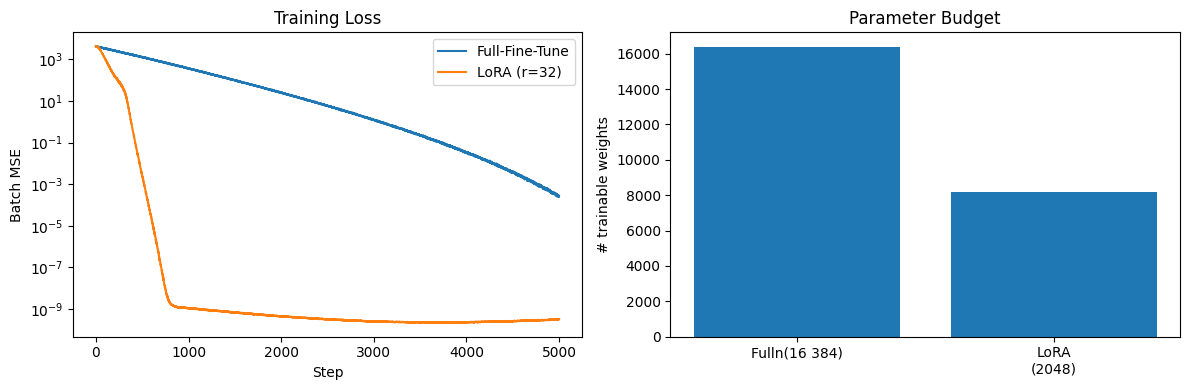

In [ ]:
# Make some plots
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(loss_full, label='Full-Fine-Tune')
ax[0].plot(loss_lora, label=f'LoRA (r={r})')
ax[0].set_yscale("log"); ax[0].set_xlabel('Step'); ax[0].set_ylabel('Batch MSE')
ax[0].set_title('Training Loss'); ax[0].legend()

ax[1].bar(['Fulln(16 384)', 'LoRA\n(2048)'],
          [16_384, r*(k+d)])
ax[1].set_ylabel('# trainable weights')
ax[1].set_title('Parameter Budget')

plt.tight_layout()
plt.show();

The training loss with LoRA decreases significally fast, because you have fewer parameters, showing how sometimes LoRA is more efficient. This is a simplier task though, if this would have been a more complex task, LoRA would decrease sooner, but when you use the Full Fine-Tune the final loss is gonna be better when you use more parameters.

But when you are working with LLM, and have billion of parameters, using LoRA could save companies millions of dollars

In [ ]:
# 5) How close to the true ΔW? -------------------------------------
with torch.no_grad():
  ΔW_true = B_true @ A_true
  ΔW_lora = model_lora.B @ model_lora.A
  ΔW_full = model_full.W - W_base
  mse = lambda a,b: ((a-b)**2).mean().item()
  print(f"ΔW MSE  LoRA : {mse(ΔW_lora, ΔW_true):.2e}")
  print(f"ΔW MSE  Full : {mse(ΔW_full , ΔW_true):.2e}")

ΔW MSE  LoRA : 1.22e-12
ΔW MSE  Full : 2.04e-06


# Bfloat16 vs Float32

Using different types of number, instead of using Float32 for various operations we use Bfloat32. This is a tecnique used to improve the training, but it should not confused with quantization, because when you quantize a number or a training you essentially change the **data type** so you change it for example from *float32* to *integer*.

With mixed precision training, or when we use **Float32 vs Bfloat16** during training we are not changing the type from Float to integer, we are just changing to a different type of Float. Float32 is able to hold a lot of information but it takes up a lot more memory then for example Bfloat16 (16 bit)

## 1. Understanding Floating-Point Components

A floating-point number is represented in a form of scientific notation, typically composed of three parts:

* **Sign**: A single bit indicating if the number is positive (0) or negative(1)
* **Exponnent**: Determines the number's magnitude or range. It tells the computer the range the number is, this number could be between this and this value.
* **Mantissa**: Determines the number's precision. More mantissa bits mean higher precision.
>Imagine you have two rulers, both one meter long. Their range is the same (0 to 1
meter).
Float32 is like a ruler with millimeter markings. It’s very precise. You can accurately
measure 51.1 cm, 51.2 cm, etc.
Bfloat16 is like a ruler that only has markings for every full centimeter. It has the same
length (range), but you can’t measure with the same precision. You can see something is
about 51 cm, but you can’t tell if it’s 51.1 or 51.2.
This is the trade-off: bfloat16 keeps the same measurement length (range) as float32 but
uses fewer markings (lower precision) to save space.
> This is why during training you can use Bfloat16 because it is actually quite similar to how a float32 behaves.

## 2. Visual comparison: Float32 vs. Bfloat16

The key difference between the standard 32-bit float (Float32) and the 16 bit brain float (Bfloat) is how they allocate their bits between the exponent and the mantissa.

### 2.1 Flaot32 (single Precision)

Float32 uses 32 bits to offer a balance of high precision and a wide dynamic range.

* Total bits: 32
* Layout: 1 sign bit, 8 exponent bits, 23 mantissa bits

S EEEEEEEE MMMMMMMMMMMMMMMMMMMMMMM

### 2.2 Bfloat16 (brain float)

Bfloat16 uses 16 bits. It was designed for AI and ML, where a wide range is morecritical than high precision.

* Total bits: 16
* Layout: 1 sign bit, 8 exponent bits, 7 matissa bits

S EEEEEEEE MMMMMMM

## 3. Key takeaways

* **Range is Identical**: Both formats use 8 exponent bits. This means they can represent
the same enormous range of numbers (from approx. 1.2 × 10−38 to 3.4 × 1038). Bfloat16
does not sacrifice the ability to handle very large or very small values.
* **Precision is the Trade-Off**: The difference lies in the mantissa. Float32’s 23 bits provide high precision (many significant digits), while Bfloat16’s 7 bits offer lower precision.
This trade-off makes Bfloat16 half the size, leading to significant memory savings and
faster computations in hardware that supports it, which is ideal for machine learning
workloads.

> So, Bfloat16 is not as precise but for our calculations it turns out that when we use Bfloat16 we get a significant amount of speed during training and you lose only very litle data in the precision trade-off.


## Comparing Bfloat16 Vs Float32 Programatically

In [ ]:
import torch

In [ ]:
# Create a large random tensor with 1 billion elements
# This simulates the size of a large model's parameters
num_elements = 1_000_000_000 # 1 billion elements
type(num_elements)

int

In [ ]:
# Tensor in standard float32 format
tensor_fp32= torch.randn(num_elements, dtype=torch.float32)

In [ ]:
# See the shape, type
print(f"Tensor shape: {tensor_fp32.shape}")
print(f"Tensor type: {type(tensor_fp32)}")
print(f"Tensor data type in the tensor: {tensor_fp32.dtype}")
print(f"See the tensor: {tensor_fp32}")

Tensor shape: torch.Size([1000000000])
Tensor type: <class 'torch.Tensor'>
Tensor data type in the tensor: torch.float32
See the tensor: tensor([ 0.0468, -0.0229,  1.5815,  ..., -0.4454,  1.7068,  1.1766])


In [ ]:
# Tensor in bfloat16 format
# we create it in fp32 first and then convert it, which is a common practice
tensor_bf16 = tensor_fp32.to(dtype=torch.bfloat16)

In [ ]:
# See the shape, type
print(f"Tensor shape: {tensor_bf16.shape}")
print(f"Tensor type: {type(tensor_bf16)}")
print(f"Tensor data type in the tensor: {tensor_bf16.dtype}")
print(f"See the tensor: {tensor_bf16}")

Tensor shape: torch.Size([1000000000])
Tensor type: <class 'torch.Tensor'>
Tensor data type in the tensor: torch.bfloat16
See the tensor: tensor([ 0.0469, -0.0229,  1.5781,  ..., -0.4453,  1.7031,  1.1797],
       dtype=torch.bfloat16)


Reminder:

1. El Cálculo (Bits a Bytes)
torch.float32 significa "Floating Point de 32 bits".

* Las computadoras almacenan la memoria en Bytes, no en bits individuales.

* Sabemos que 1 Byte = 8 bits.

2. ¿Por qué es importante en tu código?En tu script estás creando un tensor con 1 billón (1,000,000,000) de elementos.Gracias a element_size(), puedes calcular la memoria RAM exacta que consumirá esa variable:
* Cantidad: 1,000,000,000 elementos.* Peso unitario: 4 bytes.
* Total: 4,000,000,000 bytes $\approx$ 4 GB de RAM.

Comparación con bfloat16

Si ejecutaras tensor_bf16.element_size(), te retornaría 2.
* bfloat16 son 16 bits.
* $16 / 8 = 2 \text{ bytes}$.
* Tu tensor de 1 billón de elementos en este formato solo ocuparía 2 GB (la mitad).Por esto hacemos Quantization (QLoRA): pasamos de 4 bytes por parámetro a 0.5 bytes (4-bit), reduciendo el modelo 8 veces su tamaño.


In [ ]:
tensor_fp32.element_size(), tensor_bf16.element_size()

(4, 2)

In [ ]:
# Calculate the memory size in Gigabytes (GB)
size_fp32_gb = tensor_fp32.element_size() * tensor_fp32.nelement() / (1024**3)
size_bf16_gb = tensor_bf16.element_size() * tensor_bf16.nelement() / (1024**3)

In [ ]:
print(f"Size of float32 tensor: {size_fp32_gb:.2f} GB")
print(f"Size of bfloat16 tensor: {size_bf16_gb:.2f} GB")

Size of float32 tensor: 3.73 GB
Size of bfloat16 tensor: 1.86 GB


In [ ]:
# A number with lots of a decimal detail
original_number = 3.141592653523452345235235234523452352345234523452352345234

In [ ]:
# Store it in both formats
num_fp32 = torch.tensor(original_number, dtype=torch.float32)
num_bf16 = torch.tensor(original_number, dtype=torch.bfloat16)

In [ ]:
print(f"Original Number: {original_number}")
print(f"Stored as float32: {num_fp32.item()}")
print(f"Stored as bfloat16: {num_bf16.item()}")

Original Number: 3.1415926535234524
Stored as float32: 3.1415927410125732
Stored as bfloat16: 3.140625


The precision is not as good as it is with float32

In [ ]:
import torch
import time

In [ ]:
# set device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# this cell is just to see something
matrix_size = 4096
a = torch.randn(matrix_size, matrix_size, device=device)
a.shape

torch.Size([4096, 4096])

In [ ]:
# Ensure we are using a GPU
if not torch.cuda.is_available():
  print('Please enable GPU in Runtime -> change runtime type')
else:
  # Create large matrices on the GPU
  matrix_size = 16000
  a = torch.randn(matrix_size, matrix_size, device=device)
  b = torch.randn(matrix_size, matrix_size, device=device)

  # Time the float32 multiplication
  start_time_fp32 = time.time()
  torch.matmul(a, b)
  end_time_fp32 = time.time()
  print(f'Time for float32 multiplication: {end_time_fp32 - start_time_fp32:.4f} seconds')

  # Convert matrices to bfloat16
  a_bf16 = a.to(torch.bfloat16)
  b_bf16 = b.to(torch.bfloat16)

  # time the bf float multiplication
  # we use torch.cuda.amp.autocast to ensure hardware acceleration is used
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
    start_time_bf16 = time.time()
    torch.matmul(a, b)
    end_time_bf16 = time.time()
    print(f'Time for bfloat16 multiplication: {end_time_bf16 - start_time_bf16:.4f} seconds')

Time for float32 multiplication: 0.0901 seconds
Time for bfloat16 multiplication: 0.0188 seconds


/tmp/ipython-input-4124848313.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


By using bloat16 you are gonna use less compute and capacity that it is almost worth it to use bfloat 16 vs floating32

# Setting up the QLoRA Training Script with Mixed Precision & Double Quantization

We are gonna start writing our python script. Let's save it on the script folder. The script file is goingto be called as "run.clm.py"

## Setting up Imports and Libraries for the Train Script

In [ ]:
import os # interact with the operating system
import argparse # we are pssing the hyperparamters, source_dir, etc

from transformers import (
    AutoModelForCasualLm, # this allows us to load any casual llm model through the transformer library
    AutoTokenizer, # this handles text tokenization
    set_seed, # for reproducibility
    default_data_collator, # batches data automatically
    BitsAndBytesConfig, # Used for 4 bit quantized model loading
    Trainer, # high level training API
    TrainingArguments # Better communication with the trainer through the trainer arguments
)

from datasets import load_from_disk # loads a huggingface dataset saved on disk. So when we trained the model we tell where the dataset is

import torch

import bitsandbtytes as bnb # thats for efficient 4 bit training
from huggingface_hub import login, HfFolder # this is to fetch your huggingface hub token and login

## Argument Parsing Function Part 1

We are going to create the `parse_arg()` which is gonna pass the arguments we send from the notebook in to our train script.

Some key points:

`gradient_check()`:

Is a tecnique to save a significat amount of gpu memory during model training, at a cost of a small increase in training time. When you train deep neural network your GPU need to store all the intermediate activations which are the results of every layer during the forward pass, because this are going to be needed later on to compute the gradients for backpropagation during the backward pass, and for very large models like LLMs that has billions of parameters this eats up a lot of gpu memory and sometimes the model does not fit on the gpu memory. And usualy what happens is the model's transformers blocks like the attention layers the MLP layers are the one that get gradient check pointed.

When you have the forward pass the model compute the full forward pass, however it only saves activations at selected major activation checkpints. So activations for layers between checkpoints are not saved to memory.

When the backward pass needs an activation for a layer without a saved activation, it simply recomputes the forward pass starting from the nearest previous checkpoint up to that layer.

Basically, when we do the forward pass there are a lot of activations that we save, but dont save all of them, we only saves the ones at major checkpoints, after an attention layer, MLP layer, those layers that took a lot of computation. Now, when the model is doing backpropagation to calculate the gradients, some of this activation will be missing so what it does on the fly, it recalculates the forward pass for that part where the activations re messing, and it simply recomputes the gradients.

-> So the additional training time comes because it will do the forward pass several times when it is not at a major checkpoint but that means it doesnt have to save all the activations from the forward in one.

Thats make it cheaper for us, because although the training time will increse by 10%, 20% because we use less GPU memory we dont need as powerful of a GPU, so that means we actually save money by selecting a smaller gpu even though it takes a little more time to train.

## Heads up...

Not all of the arguments are passed by the LLM notebook such as `gradient_checkpointing`, that is why we set default values



In [ ]:
def parse_arge():
  parser = argparse.ArgumentParser()

  # add the stuff to the parser
  parser.add_argument(
      "--model_id",
      type = str,
      help = "Model id used for training"
  )

  parser.add_argument(
      "--dataset_path",
      type = str,
      default = 'lm_dataset',
      help = 'path to dataset'
  )

  parser.add_argument(
      "--hf_token",
      type = str,
      default = HfFolder.get_token(),
      help = "hf token"
  )

  parser.add_argument(
      "--epochs",
      type = int,
      default = 3,
      help = "number of epochs to run for"
  )

  parser.add_argument(
      "--per_device_train_batch_size",
      type = int,
      default = 1,
      help = "batch size to use per training"
  )

  parser.add_argument(
      "--lr",
      type = float,
      default = 5e-5,
      help = "learning rate to use for training"
  )

  parser.add_argument(
      "--seed",
      type = int,
      default = 91,
      help = "seed to use for training"
  )

  parser.add_argument(
      "--gradient_checkpointing",
      type = bool,
      default = True,
      help = "Use or not use gradient checkpointing"
  )

  parser.add_argument(
      "--bf16",
      type = bool,
      default = True if torch.cuda.get_device_capability()[0] == 8 else False,
      help = " Whether to use bf16 or not"
  )

  parse.add_argument(
      "--merge_weights",
      type = bool,
      default = True,
      help = "Whether to merge LoRA weights with the base model's weights"
  )

  args, _ = parser.parse_known_args()

  if args.hf_token:
    print("logging into hf hub with token")
    loging(token=args.hf_token)

  return args

Understanding Trainable Parameters Caveats

We are gonna write a function that helps us tell how many trainable parameters our model is going to have.

`use_4bit=False`

The reason why the use_4bit is False is because of the parameters were actually training the LoRA adopters, arent 4 bit. They are going to behandled using bloat 16. We do load and save the model with quantizatio, with 4 bit weights but we are not gonna be training this weights, because when we traine the model we are gonna be using bflaot16.

`trainable_params = 0` and `all_param = 0`

We start with 0 for both of them, because we have paramaeters that are not trainable, and then we find which one of the parameters are trainable.

`for -, param in model.named_parameters():`

we loop through all the named parameters in the model, so each param that we loop through is a Tensor, for example it is a layer weights matrix or a bias vector. We are not looping through 7 billion parameters. Eas of these param is a tensor or a weight matrix.

`if num_params == 0 and hasattr(param, "ds_numel"):
      num_params = params.ds_numel`
* numel(): Number of Elements
> Si una matriz (capa) tiene dimensiones $100 \times 100$, numel() devuelve $10,000$. Es el conteo bruto de "neuronas" en esa capa.

If we are using DS03 and the weights are intialized empty, then there is a special case.

DSnuml essentially it's a memory optimization technique and when we use this deep seed 0 stage3, it may create empty tensors

¿Por qué un parámetro tendría tamaño 0? Esto sucede cuando usas una tecnología llamada DeepSpeed ZeRO-3 (Zero Redundancy Optimizer).

* El Problema: Cuando entrenas modelos gigantes en varias GPUs, a veces el modelo es tan grande que no cabe en una sola tarjeta.

* La Solución (ZeRO-3): DeepSpeed "parte" el modelo en pedacitos y los reparte entre las GPUs.

* El Efecto: Si estás en la GPU #1 y preguntas por el tamaño de una capa que está guardada en la GPU #2, tu GPU la ve como "vacía" (tamaño 0) porque no la tiene cargada en su RAM local.

* La Corrección: Aunque el tamaño local sea 0, el atributo ds_numel (DeepSpeed Number of Elements) guarda el dato real de cuánto pesa esa capa globalmente. Este if asegura que contemos el tamaño real del modelo, incluso si está fragmentado en varios servidores.


In [ ]:
def trainable_parameters(model, use_4bit=False):

  trainable_params = 0
  all_param = 0

  for _, param in model.named_parameters():
    num_params = param.numel() # number of params

    if num_params == 0 and hasattr(param, "ds_numel"):
      num_params = param.ds_numel

    all_param += num_params

    if param.requires_grad:
      trainable_params += num_params

  if use_4bit:
    trainable_params /= 2

  print(
      f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params/all_param}"
  )

# Introduction to Quantization

The important key here is memory efficient at scale.

When you fine tuning a 7 billion parameter model, storing all those weights in full precision with floating poit number like float 16, float 32, would require immense memory. That's why we use INT4, because it reduces memory 70% 75%, but there is a crucial part. INT4 quantization doesnt just store 4 bit integers it also stores this numbers called scaling factores that are floating point numbers. And those scaling factors tell us how to convert those INT 4 integers back to the orignial range. This is important because when we train a model we can't train it with INT4, the precision would be way off and the gradients would be all over the place.

When you save a model with INT4 weights, you also save the scalling factors, which are these small numbers that allow us to convert the INT4 weights back to floating poit numbers, they wont  be exactly like how they were when you originally saved from floating point numbers to integers, but they are going to be very close enough. This allows us to basically reconstruct the INT4 weights back to a floating precision-based weights.

During training or fine-tuinig, we cant do math with int 4 weights because the precision is too low,so every time we need to compute something, we take those int 4 values, we multiply by their scaling factor to de-quantize them back to, in our case, Bfloat16, we do the computation with the Lora adapters, which are the A and B matrices, which are also in Bfloat 16 and then we throw away the temprary Bfloat16 values for the original weights. And so the original int 4 weights and their scalling factors stay frozen in memory.

## To conclude

You get the memory footprint of INT 4 storage integers plus the scaling factores, but you you also get the numerical stability of Bfloat 16 computation.

So without this trick, you couldnt fine-tune large models on consumer GPUs.

## QLoRA: Simple Flow

1. Loading

* Base model: INT4
* LoRA Adapters: BFLOAT16 (Two smaller matrices A and B)

2. Training (Forward Pass)

* INT4 Weights -> dequantize -> BFLOAT16 + LoRA = Output

> INT4 weights temporarity converted to BFLOAT16 for computation only

3. Saving Final Model

INT4 Base -> dequantize -> FP16 + LoRA = Final model: FP16

> Key point: INT4 is only or storage/memory savings. All actual math happens in BFLOAT16.

### What you need to understand is that...

You load the model, the integer 4-based weights, with their integer scaling numbers.

INT4 weights temporarity converted to BFLOAT16 for computation only, and the we can simply add the Bfloat16 LoRA to is as well, and we get the final output. Rememer the scaling factors are what allows to dequantize the info weights.

When we save the model, we essentially look and take at the INT4 weights, we dequantize thme to bfloat 16 or normal floating point 16 bits, we add to it the LoRA adapters, and then we save the mode in FP16.

## Note about quantization

Quantization actually cahnges the datatype to integers like int8 or int4. Bfloat16 is when you have reduce precision floating point training, and that's when the training is still done infloates but in a reduced precision. So, we do convert weights from float32 or float 16 into int8 or int4, when you load or save the model, but during forward computation weights are dequantized to bfloat16 for the math operations.


El truco de ingeniería es la Cuantización por Bloques **(Block-wise Quantization)**:
* Agrupamos los pesos en bloques (por ejemplo, grupos de 64 pesos).
* Esos 64 pesos comparten un solo scaling factor en Float32.
**El ahorro es brutal:**
* 64 pesos en INT4 = $64 \times 4 \text{ bits} = 256 \text{ bits}$.
* 1 scaling factor en FP32 = $32 \text{ bits}$.
* Total: 288 bits.
* (Si fuera todo en FP16 original: $64 \times 16 = 1024 \text{ bits}$).

# Identifying Trainable Layers for LoRA


We are going to create findAllLinear function. And we will use the list that this function returns to us to tell LoRA which Layers to inject trainable adapters into, or trainable weights. So essentially we are gonna find all the Linear Layers to which we can insert our smaller matrices.

`bnb.nn.Linear4bit`:

Remember that we have loaded the model (weights) in 4 bits so that is the Lienar Layer we need to search, which is quantized layer of type bnb.nn.Lienar4bit since that is where LoRA can be applied. For matrix operation we are gonna transform it in float16

Helps destinguish which are this linear layer we can inject LoRA adapters, the smaller matrices that we can multiply and then add to the frozen weight matrix.

Esta función es tu detector de metales automático. Su trabajo es escanear todo el edificio del modelo (Mistral) y marcar con una "X" todas las paredes donde se puede hacer la obra (inyectar LoRA).Específicamente, hace lo siguiente:
1. El Escaneo (El Loop) Recorre cada rincón del modelo, revisando capa por capa (`model.named_modules()`).
2. El Filtro (El `isinstance`) Aquí aplica lo que acabas de aprender.
* Mira una capa y pregunta: "¿Eres una ecuación lineal ($ax+b$) comprimida en 4 bits?" (`bnb.nn.Linear4bit`).
* Si la respuesta es SÍ, la marca como candidata.
* Si es una capa de normalización o activación, la ignora.
3. La Limpieza de NombresLos nombres internos de PyTorch son largos y feos, tipo: `model.layers.0.self_attn.q_proj`.
* La función corta todo eso y se queda solo con el "apellido" importante: `q_proj`, `v_proj`, `gate_proj`, etc.
* Usa un `set()` para no tener repetidos (porque `q_proj` aparece en cada una de las 32 capas del modelo, pero solo necesitamos el nombre una vez).
4. La Regla de Seguridad (`lm_head`)
Al final, verifica si marcó la "lm_head" (la última capa lineal que decide qué palabra sale).
* Acción: Si está en la lista, la borra.
* Razón: En QLoRA, tocar la capa de salida suele causar problemas matemáticos. Queremos que el modelo aprenda a razonar mejor (capas internas), no solo a cambiar la última palabra.

Resultado Final (Output)

La función te devuelve una lista limpia, por ejemplo:`['q_proj', 'up_proj', 'o_proj', 'k_proj', 'down_proj', 'gate_proj', 'v_proj']`
¿Para qué sirve esto?Le entregas esta lista a la configuración de LoRA (LoraConfig) y le dices: "Toma, pon adaptadores en todas estas, no quiero tener que escribirlas a mano una por una".

In [ ]:
def find_all_linear_names(model):
  """
  This will detect which layer to inject LoRA into.
  """

  lora_module_names = set()

  for name, module in model.named_module():
    if isinstance(module, bnb.nn.Linear4bit): # on the fly we will convert them to floatin pointweights
      names = names.split(".")
      lora_module_names.add(names[0] if len(names) == 1 else names[-1])

  if "lm_head" in lora_module_names:
    lora_module_names.remove("lm_head")

  return list(lora_module_names) # example output['q_proj', 'v_proj']

In the upcoming videos we are gonna be uploading the model from the hugging face hub with `bnb.nn.Linear4bit`

# Setting up Parameter Efficient Fine Tuning

We are going to create `create_peft _model()`, this function is gonna be responsible for a lot optimization for our model, so it will inject the LoRA adaptares into the quantized model, it will enable gradient checking and adjust the datype where appropiate. Remeber to use bfloat 16.

`TaskType`:

Tells the pfet, or the parameter efficient fine tuning from which we just imported from and which we can then use when we train a model. It tells the task that you are fine tuning the model. Here we are gonna have to specify that we will use casual LLM which is a decoder only, which are like ChatGPT for example.

`prepare_model_for_kbit_trainig`

this makes 4bit models trainable.

`from pfet.tuners.lora import loralayer`

This is going to be used to identify Lora-injected modules later on.

`lora_alpha = 16`

It is a scalling factor that multiplies the LoRA adapter output before it is added to the frozen weight. Alpha controlls how strongly LoRA updates influence the model. This is for avoiding overfitting. This is for how much we want to update the weight, so we are trying to not make it as agresive.

La relación $r$ y $\alpha$:El impacto de los adaptadores se escala mediante la fórmula: $\Delta W \times \frac{\alpha}{r}$.
* Aquí tienes $16 / 64 = 0.25$.
* Significa que las actualizaciones de LoRA se suavizan (se multiplican por 0.25) antes de sumarse. Esto ayuda a que el entrenamiento sea más estable y no "rompa" el conocimiento previo del modelo bruscamente.

`mix_precision_training`

this will speed up training with very good accuracy.

`model = get_peft_model(model, pfet_conig)`

Este es el momento exacto donde el modelo cambia.
Antes de esta línea, tenías un modelo Mistral normal (comprimido). Después de esta línea, tienes un modelo híbrido con matrices $A$ y $B$ pegadas a todas las capas lineales que encontró tu función buscadora.


`if "norm" in name`

if the layers whose names containing norm like layer norm, or RMS norm those are numerically sensitive and should stay in float32 for stability. Casting them to lower precision like BF16 could cause training instability.




Remember: we are not training anything in 4 bit, we are loading the model and during training they are in 4bit but whenever those specific weights need any matrix multiplication or matrix operation on them it will convert it on the fly to a Floating point number.

In [ ]:
def create_peft_model(model, gradient_checkpointing = True, bf16 = True):
  """
  This function is going to set up the LoRA config and also
  implement mix precision training.
  """

  from peft import (
      get_peft_model,
      LoraConfig, # defines the LoRA injection parameters
      TaskType,
      prepare_model_for_kbit_training
  )

  from peft.tuners.lora import loralayer

  model = prepare_model_for_kbit_training(
      model, use_gradient_checkpointing=gradient_checkpointing
  )

  # Enabling gradient_checkpointing if it is requested
  if gradient_checkpointing:
    model.gradient_checkpointing_enable()

  # Implement LoRA Configuration and Mixed Precision Training
  modules = find_all_linear_names(model)
  print(f"Found {len(modules)} modules to quantize: {modules}")

  pfet_config = LoraConfig(
      r = 64,
      lora_alpha = 16,
      target_modules = modules, # La lista automática que creamos antes ('q_proj', etc.)
      lora_dropout = 0.1,
      bias = "none",
      task_type = TaskType.CAUSAL_LM
  )

  model = get_peft_model(model, pfet_conig)

  for name, module in model.named_modules():
    if isinstance(module, LoraLayer):
      if bf16: # set true above
        module = module.to(torch.bfloat16) # here we are converting the LoraLayer into bf16 for faster computation and lower memeory usage

    if "norm" in name:
      module.to(torch.float32)

    if "lm_head" in name or "embed_tokens" in name:
      if hasattr(module, "weight"):
        if bf16 and module.weight.dtype == torch.float32:
          module = module.to(torch.bfloat16)

  model.print_trainable_parameters()

  return model

# Understanding Double Quantization

Remember that quantization compresses neural networks from 32 bit floats to smaller flots like 4 bit integer to save memory. But you need scalling factors, which are floats, to converting back to useful weights during our process, whatever we are doing inference or training, and double quantizations go even more further, it also compresses those scaling factors from float to integers, but to turn those compress scale factors back into usuable floats you need new scaling factores, those are the **Meta Scales**.

So basically, it is like compressing the compression parameters. And you still need some float parameters and these meta scales must stay as floats, but you need far fewer o them. So one meta scale per large block of thousand of weights instead of one scale per small group of, for example, 128 weights.

## Double Quantization Process

*Post-training quantization Process*

1. Trained Model (FP32 weights)
2. Quantize Weights (4-bit integers)
3. Quantize Scales (8-bit integers)

> What gets saved:
Quantized weights + Quantized scales + Meta-Scañes (FP32)

This compressed model can now be distributed and used!

## Usage Phase (Reconstruction)

Two-Step reconstruction:

Meta-scales -> Scales -> Weights

**Step 1**: Dequantize scales (Using meta-scales)
-> You reconstruct weights by first turning the compress scale back into usuable scales using the meta-scales
**Step 2**: Dequantize Weights (using re constructed scales)
-> Using those reconstructed scales to de-quantize the actual weights.
**Final**: Ready for computation

### When to we quantize

* Fine tuning

Dequantize base weights for gradient computation (weights stay frozen)

* Inference

Dequantize weights for final predictions

Vamos a hacer la "contabilidad de bits" exacta para que visualizar dónde está el ahorro. Es pura matemática de optimización.

La clave es entender que en un modelo gigante, los Scaling Factors **(esas "leyendas" en Float32)** son tantos que empiezan a pesar mucho.

Supongamos la configuración estándar de QLoRA: Bloques de 64 pesos.

**1. Escenario A: Sin Double Quantization (Solo INT4)**

Aquí comprimimos los pesos, pero dejamos los scaling factors en calidad original (32-bits).
* **Los Pesos**: 1 bloque tiene 64 pesos de 4-bits.$$64 \times 4 = 256 \text{ bits}$$
* **El Scaling Factor**: Necesitamos 1 número Float32 por bloque.$$1 \times 32 = 32 \text{ bits}$$
* **Costo Promedio por Peso**:$$\text{Overhead} = \frac{32 \text{ bits (scale)}}{64 \text{ pesos}} = \mathbf{0.5 \text{ bits por peso}}$$

**Conclusión A**: Además de los 4 bits del dato, estás gastando 0.5 bits extra por cada parámetro en "metadata".

---

**2. Escenario B: Con Double Quantization**

Aquí aplicamos la recursividad: tomamos esos Scaling Factors (que eran Float32) y los **cuantizamos a 8-bits (FP8)**.

Para hacer esto, agrupamos los Scaling Factors en bloques de 256 (un "bloque de bloques").

* Los Pesos: Siguen igual (4 bits).
* El Scaling Factor (Comprimido): Ahora cada bloque de 64 pesos tiene un scale de solo 8 bits.$$\frac{8 \text{ bits}}{64 \text{ pesos}} = 0.125 \text{ bits por peso}$$
* El Meta-Scale (Nuevo): Necesitamos 1 Float32 para "descomprimir" el grupo de 256 scales.$$\frac{32 \text{ bits}}{256 \times 64 \text{ pesos}} = 0.0019 \text{ bits por peso}$$(Es despreciable).
* **Costo Promedio Total**:$$\text{Overhead} = 0.125 + 0.002 \approx \mathbf{0.127 \text{ bits por peso}}$$

---

**3. El Resultado Final (La Diferencia)**
Vamos a comparar el "impuesto" de memoria (overhead) que pagas por mantener la precisión:

| Método | Costo extra por Peso | Ahorro |
| :--- | :---: | :---: |
| Single Quantization | 0.5 bits | - |
| Double Quantization | 0.127 bits | 0.373 |

Puede parecer poco (0.37 bits), pero multiplícalo por un modelo grande:

**Para un modelo Llama-65B (65 Billones de parámetros):**

$$65,000,000,000 \times 0.373 \text{ bits} \approx 24,245,000,000 \text{ bits}$$$$\approx \mathbf{3 \text{ GB de VRAM ahorrados}}$$

**Resumen para tu bolsillo**

Esos 3 GB extra que te ahorra la Double Quantization son la diferencia entre que el modelo quepa en una tarjeta gráfica de consumidor (como una RTX 3090 o 4090 de 24GB) o que tengas que alquilar un servidor industrial A100 mucho más caro.Es una optimización pequeña a nivel unitario, pero masiva a escala.

# Creating the Training Function Part 1 & 2

We are gonna start creating our training function.

`dataset = load_from_disk(args.dataset_path)`

Loads a process dataset saved locally at the args.dataset_path, and this is our tokenized text dataset ready for casual language modelling.

`load_in_4bit = True`

Load the model in 4 bit precision instead of the full 16 or 32 bit precision. And this actually repleces the standard linear layer with `bnb.nn.Linear4bitLayer`, which is why we can look for these layer in `find_all_linear_names()`

`bnb_4bit_quant_type = "nf4"`

This specifies the quantization format to use for converting full precision weights into 4 bit values. nf4 stands for normal float 4 bit which is a custom 4 bit floating point format introduce by the bits&bytes library, and it mimics the distribution of normal floats values meaning it handle small and large number better than the standard INT4, so it improves quantization accuracy especially for transformer weights that follow a roughfly Gaussian.

`bnb_4bit_compute_dtype = torch.bfloat16`

This specifies the precision use for computation, example matrix multiplication after the weights have been dequantized from 4bits.
Remeber our model weights are stored in 4bit, nf4, for memory saving, but before computing, for example the forward pass, they get dequantized for a higher presion type and this line tells the model to do all the math, example attention layer, layer norms, activation in BFloat16 precision.
When the weights get de-quantized, it means they get reconstructed using the scale parameters.

Esta línea es crítica. Le dice a la GPU: "Guarda los datos en 4 bits para ahorrar espacio, pero cuando tengas que hacer multiplicaciones, descomprímelos a Bfloat16 para que el cálculo sea preciso, y luego vuelve a borrarlos".


`model = AutoModelForCasualLM.from_pretrained()`

this loads a pre-trained casual language model that it is use for text generation. Casual LM means each token is predicted based on the previous ones so it is a decoder only.

Aquí se descarga Mistral (o el modelo que elijas) y se aplica la configuración anterior. Al terminar esta línea, el modelo ya está en la VRAM ocupando solo ~24GB en lugar de 90GB.

`use_cache = False if args.gradient_checkpointing else True`

`gradient_checkpointing` funciona recalculando el pasado a propósito para ahorrar RAM. Son técnicas opuestas. Si activas el Checkpointing (para ahorrar memoria), estás obligado a apagar la Cache

`device_map = "auto"`

Automatically spread the model across available devices.

`trainer.train()`

`Trainer`: Es una clase de alto nivel de Hugging Face que abstrae el bucle complejo (Forward -> Loss -> Backward -> Optimizer Step).
`trainer.train()`: Es el botón de encendido. Aquí empieza el bucle for que itera sobre tu dataset, calcula el error de las matrices $A$ y $B$, y las actualiza poco a poco.

model = model.merge_and_unload()

We are gonna combine the LoRA adapter weights with the frozen model weights into a single merge model. After merging the LoRA adapter layers are unloade from memory.

Resumen Visual del Flujo
1. Entrada: Datos crudos del disco (load_from_disk).

2. Preparación: Se carga el modelo comprimido en 4-bits (nf4) con doble cuantización.

3. Modificación: Se le pegan los adaptadores LoRA.

4. Acción: trainer.train() empieza a pasar datos.

* Los datos viajan por el modelo de 4-bits (descomprimiéndose milisegundos a bf16).

* El error se calcula.

* Solo se actualizan los adaptadores.

5. Salida: Al final, tendrás un modelo base intacto y unos adaptadores pequeños entrenados listos para guardar.

In [ ]:
def training_function(args):
  set_seed(args.seed)

  dataset = load_from_disk(args.dataset_path)

  # Load the model from the hub with bnb congif
  bnb_config = BitsAndBytesConfig(
      load_in_4bit = True,
      bnb_4bit_use_double_quant = True,
      bnb_4bit_quant_type = "nf4",
      bnb_4bit_compute_dtype = torch.bfloat16
  )

  model = AutoModelForCasualLM.from_pretrained(
      args.model_id,
      use_cache = False if args.gradient_checkpointing else True, # we are using gradient checkpointing so we must disable the cache to save memory
      device_map = "auto",
      quantization_config = bnb_config,
      force_download=True
  )

  model = create_peft_model(
      model, gradient_checkpointing=args.gradient_checkpointing,
      bf16=args.bf16
  )

  # define the directory qhere the modeland the logs will be saved
  output_dir = "/tmp/mixtral"

  # define the training args in the HuggingFace training arguments
  training_args = TrainingArguments(
      output_dir = output_dir,
      per_device_train_batch_size = args.per_device_train_batch_size,
      bf16 = args.bf16,
      learning_rate = args.lr,
      num_train_epochs = args.epochs,
      gradient_checkpointing = args.gradient_checkpointing,
      logging_dir = f"{output_dir}/logs",
      logging_strategy = "steps",
      logging_steps = 10,
      save_strategy = "no"
  )

  trainer = Trainer(
      model = model,
      args = training_args,
      train_dataset = dataset,
      data_collator = default_data_collator
  )

  trainer.train()

  sagemaker_save_dir = "/opt/ml/model/"

  if args.merge_weights:
    # if LoRA is enable we are gonna save the current fine tune model with the LoRA adapters separetly to a loacal folder output directory
    # we save the model because it is still in NF4 format with separete LoRA adapters
    # this are in INT4 and we cant merge them
    # Mergin LoRA into an INT4 model isnt supported, so that is why we save it
    trainer.model.save_pretrained(output_dir, safe_serialization=False)
    # Remeber: after it is done with the fine tuning it is in int4 format


    # we deleted everything to some space because it is already save
    del model
    del trainer
    torch.cuda.empty_cache()

    from peft import AutoPeftModelForCasualLM

    # then we reload it, and this is the key part
    # we loaded back in float16, because merging LoRA into int4 model isnt supported
    # it needs higher precision
    # So we load it back in with fp16
    model = AutoPeftModelForCasualLM(
        output_dir,
        low_cpu_mem_usage = True,
        torch_dtype = torch.float16
    )

    # Once we have loaded, in a float16 format, then what we can do is
    # call the merge_and_unload(), which combines the LoRA weights into
    # the base model and this result is a float16 model
    # which can e readily used for inference without needing adopters
    model = model.merge_and_unload()

    model.save_pretrained(
        sagemaker_save_dir, safe_serialization = True, max_shard_size = '2GB'
    )
  else:
    trainer.model_save_pretrained(
        sagemaker_save_dir, safe_serialization = True
    )

  tokenaizer = AutoTokenizer.from_pretrained(args.model_id)
  tokenaizer.save_pretrained(sagemaker_save_dir)

In [ ]:
# Finishing our Sagemaker Script
def main():
  args = parse_arge()
  training_function(args)

if __name__ == "__main__":
  main()